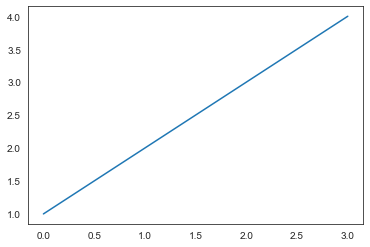

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from pprint import pprint

from collections import defaultdict

%matplotlib inline
sns.set_style("white")
plt.plot(np.arange(1,5));

In [2]:
from pyswip import Prolog
prolog = Prolog()
path = "../data/YAGO3-10-DR/train_prolog.pl"
prolog.consult(path)

In [3]:
print(list(prolog.query("rel_0('0',X) , rel_1(X,Y)")))

[{'X': '2', 'Y': '3'}, {'X': '2', 'Y': '1'}]


In [4]:
path_to_files = '../data/YAGO3-10-DR/'
project = "YAGO3-10-DR"
df_train = pd.read_csv(path_to_files+"train.txt", sep='\t', header=None, dtype='str')
df_train.columns = ['head', 'rel', 'tail']
# in case no valid.txt being there
try:
    df_eval = pd.read_csv(path_to_files+"valid.txt", sep='\t', header=None, dtype='str')
    df_eval.columns = ['head', 'rel', 'tail']
except FileNotFoundError:
    df_eval = df_train.copy()

df_test = pd.read_csv(path_to_files+"test.txt", sep='\t', header=None, dtype='str')
df_test.columns = ['head', 'rel', 'tail']
for cur_df in [df_train, df_eval, df_test]:
    #cur_df = cur_df.astype(str)
    if "YAGO" in path_to_files:
        for col in cur_df.columns:
            cur_df[col] = cur_df[col] + "_YAGO"

already_seen_triples = set(df_train.to_records(index=False).tolist() + df_eval.to_records(index=False).tolist())
print(f'Total: {len(already_seen_triples)} triples in train + eval!)')
print(f'In train: {len(df_train)}')

Total: 735915 triples in train + eval!)
In train: 732556


In [5]:
if "YAGO" in path_to_files:
    df_train.to_csv(path_to_files + "train_YAGO.txt", index=False, header=False, sep='\t')
    df_test.to_csv(path_to_files + "test_YAGO.txt", index=False, header=False, sep='\t')
    df_eval.to_csv(path_to_files + "valid_YAGO.txt", index=False, header=False, sep='\t')

In [6]:
id2rel_df = pd.read_csv("../data/YAGO3-10-DR/relations2idx.txt", sep='\t', header=None)
id2rel_orig = dict(zip(id2rel_df[0], id2rel_df[1]))
rel2id_orig = dict(zip(id2rel_df[1], id2rel_df[0]))

id2ent_df = pd.read_csv("../data/YAGO3-10-DR/entities2idx.txt", sep='\t', header=None)
id2ent_orig = dict(zip(id2ent_df[0], id2ent_df[1]))
ent2id_orig = dict(zip(id2ent_df[1], id2ent_df[0]))

In [7]:
#21_YAGO(X,Y) <= 13_YAGO(X,A), 13_YAGO(B,A), 21_YAGO(B,Y)

id2rel_orig[21], id2rel_orig[13]

('isAffiliatedTo', 'hasGender')

In [8]:
from typing import Tuple, List
def preprocess_kg_for_prolog(df: pd.DataFrame) -> Tuple[pd.DataFrame, dict, dict, dict]:
    """

    :param df:
    :return:
    """
    unique_ents = sorted(set(df['head'].values.tolist() + df['tail'].values.tolist()))
    unique_rels = sorted(list(df['rel'].unique()))
    print(f'|R|: {len(unique_rels)} , |V|: {len(unique_ents)}')

    ent_prefix = 'e'
    rel_prefix = 'r'

    rel2id = {}
    id2rel = {}
    for i, rel in enumerate(unique_rels):
        cur_rel_name = f'{rel_prefix}{i}'
        rel2id[rel] = cur_rel_name
        id2rel[cur_rel_name] = rel

    ent2id = {}
    id2ent = {}
    for i, ent in enumerate(unique_ents):
        cur_ent_name = f'{ent_prefix}{i}'
        ent2id[ent] = cur_ent_name
        id2ent[cur_ent_name] = ent

    df['head'] = df['head'].map(ent2id)
    df['rel'] = df['rel'].map(rel2id)
    df['tail'] = df['tail'].map(ent2id)
    return df, ent2id, id2ent, rel2id, id2rel

transformed_df, ent2id, id2ent, rel2id, id2rel = preprocess_kg_for_prolog(df_train)

|R|: 36 , |V|: 122780


In [9]:
transformed_df = transformed_df.sort_values(by='rel')
transformed_df.head()


,head,rel,tail
507481,e111984,r0,e905
657746,e33019,r0,e9456
657735,e6608,r0,e36510
443655,e17035,r0,e97637
46976,e17192,r0,e8449


In [10]:
def create_knowledge_base(path_to_file: str, df: pd.DataFrame, is_transformed:bool = True) -> None:
    """
    Create .pl file with predicates initialization
    :param path_to_file: str, path to folder where the .pl file will be saved
    :param df: pd.DataFrame, triples in the form of head - rel -tail
    :param is_transformed: bool, whether to transform the data first
    :return: None
    """

    if not(is_transformed):
        df, _, _, _, _ = preprocess_kg_for_prolog(df)
    unique_rels = sorted(list(df['rel'].unique()))

    # Initialize predicates
    str_ = ""
    for rel in unique_rels:
        str_ += f"{rel}/2.\n"
    str_ += "\n"

    for i, row in tqdm.tqdm_notebook(df.iterrows(), total= len(df)):
        str_ += f"{row['rel']}({row['head']}, {row['tail']}).\n"

    with open(path_to_file, 'w+') as f:
        print(f'{path_to_file}')
        f.write(str_)
    return

create_knowledge_base("../data/YAGO3-10-DR/train_prolog_full.pl", transformed_df)


/Users/Konstantinos.Bougiatiotis@ey.com/anaconda3/envs/lola/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/732556 [00:00<?, ?it/s]

../data/YAGO3-10-DR/train_prolog_full.pl


In [27]:
import time
from pyswip import Prolog
print(f'DB stats:')
print(f'|V|: {len(ent2id)} \t |R|: {len(rel2id)} \t |G|: {len(transformed_df)}')
time_s = time.time()
prolog = Prolog()
path = "../data/YAGO3-10-DR/train_prolog_full.pl"
prolog.consult(path)
time_took = (time.time() - time_s)
print(f'Time took to consult the db: {time_took:.2f} seconds ({time_took/60:.2f} mins)')

DB stats:
|V|: 122780 	 |R|: 36 	 |G|: 732556
Time took to consult the db: 7.95 seconds (0.13 mins)


In [29]:
# 337	262	0.7774480712166172	21_YAGO(X,17_YAGO) <= 21_YAGO(X,9_YAGO)

print(id2rel_orig[21], id2ent_orig[9],id2ent_orig[17])

time_s = time.time()
body = list(prolog.query(f"{rel2id['21_YAGO']}(X, {ent2id['9_YAGO']})"))
body_and_head = list(prolog.query(f"{rel2id['21_YAGO']}(X, {ent2id['9_YAGO']}), {rel2id['21_YAGO']}(X, {ent2id['17_YAGO']})"))
print(len(body), len(body_and_head), len(body_and_head) / len(body))
time_took = (time.time() - time_s)
print(f'Time took to run 2 queries: {time_took:.2f} seconds ({time_took/60:.2f} mins)')

isAffiliatedTo 1._FC_Cologne 1._FC_Köln
337 262 0.7774480712166172
Time took to run 2 queries: 0.03 seconds (0.00 mins)


In [30]:
for item in prolog.query(f"{rel2id['21_YAGO']}(X, {ent2id['9_YAGO']}), {rel2id['21_YAGO']}(X, {ent2id['17_YAGO']})"):
    print(id2ent_orig[int(id2ent[item['X']].split('_')[0])])

Flemming_Povlsen
Mustafa_Doğan
Holger_Willmer
Spasoje_Bulajič
Lukas_Sinkiewicz
André_Oliveira_de_Lima
Daniel_Chitsulo
Vassilios_Tsiartas
Tomoaki_Makino
Ralf_Sturm
Sebastian_Helbig
Stefan_Kohn
Janosch_Dziwior
André_Trulsen
Srđan_Čebinac
Edhem_Šljivo
Attila_Tököli
Heinz_Flohe
Horst_Heldt
Andriy_Voronin
Boris_Živković
Marvin_Matip
Bodo_Illgner
Wilfried_Sanou
Christian_Timm
Ümit_Özat
Darko_Pivaljević
Dominique_Ndjeng
Marcel_Gebhardt
Matthias_Lehmann
Rico_Steinmann
Pierre_Womé
Kostas_Giannoulis
Karl-Heinz_Spikofski
Vladan_Grujić
Heinz_Hornig
Uwe_Scherr
Ralph_Hasenhüttl
Andreas_Menger
David_Pizanti
Dietmar_Beiersdorfer
Marcus_Steegmann
Kevin_McKenna
Pedro_Geromel
Lars_Leese
Franz_Krauthausen
Bernhard_Cullmann
Frederic_Löhe
Paul_Alger
Paul_Steiner
Kim_Christofte
Andrzej_Rudy
André_Ricardo_Soares
Rolf-Christel_Guié-Mien
Karsten_Hutwelker
Frank_Paulus
Revaz_Arveladze
Dirk_Lottner
Sunday_Oliseh
Youssef_Mohamad
Dennis_Grassow
Marco_Streller
Christopher_Schorch
Marco_Quotschalla
Sergiu_Radu
Pekka_

In [31]:
f"{rel2id['9_YAGO']}(X, {ent2id['9_YAGO']})"


'r35(X, e122779)'

In [32]:
transformed_df[(df_train['rel'] == rel2id['9_YAGO']) & (transformed_df['tail'])==ent2id['9_YAGO']]

TypeError: unsupported operand type(s) for &: 'bool' and 'str'

In [33]:
def binary_atom_splitter(atom:str)-> Tuple[str, str, str]:
    """
    Gets a binary atom in AnyBURL format and outputs a triple in the from (predicate, subject, object).
    e.g. "rel1(X,Y)" => (rel1, X, Y)
    :param atom: string, predicate in AnyBURL format
    :return: Tuple(str, str, str): predicate in format (relation, subject, object)
    """
    rel, rest = atom.split("(")
    # drop the last parenthesis
    rest = rest[:-1]
    arg1, arg2 = rest.split(",")
    return (rel, arg1, arg2)

def get_atoms_splitted(rule:str) -> Tuple[Tuple[str, str, str], List[Tuple]]:
    """

    :param rule:
    :return:
    """
    head, body = rule.split(" <= ")
    head_atom = binary_atom_splitter(head)
    body_atoms_strings = body.split(', ')
    body_atoms = [binary_atom_splitter(b_a) for b_a in body_atoms_strings]
    return head_atom, body_atoms

#157	23	0.1464968152866242	21_YAGO(X,Y) <= 21_YAGO(X,A), 21_YAGO(A,Y)

# rule = "21_YAGO(X,17_YAGO) <= 21_YAGO(X,9_YAGO)"
rule = "21_YAGO(X,Y) <= 21_YAGO(X,A), 21_YAGO(A,Y)"
#rule = "P530(X,Q851) <= P463(X,Q4783148)"

head_atom, body_atoms = get_atoms_splitted(rule)
print(body_atoms)
# head, body = rule.split(" <= ")
# body_atoms = body.split(', ')
# print(binary_atom_splitter(head))
# print([binary_atom_splitter(b_a) for b_a in body_atoms])

[('21_YAGO', 'X', 'A'), ('21_YAGO', 'A', 'Y')]


In [34]:
import string
def generate_prolog_query(atoms:List[Tuple], ent2id, rel2id) -> str:
    """

    :param atoms:
    :param ent2id:
    :param rel2id:
    :return:
    """
    variables = set(string.ascii_uppercase)
    query = ""
    for atom in atoms:
        # subject mapping
        if atom[1] in variables:
            arg1 = atom[1]
        else:
            arg1 = ent2id[atom[1]]

        # object mapping
        if atom[2] in variables:
            arg2 = atom[2]
        else:
            arg2 = ent2id[atom[2]]
        query += f"{rel2id[atom[0]]}({arg1}, {arg2})"
        query += ", "
    # remove last two chars ', '
    query = query[:-2]
    return query

def generate_prolog_rule(atoms:List[Tuple], ent2id, rel2id) -> str:
    """

    :param atoms:
    :param ent2id:
    :param rel2id:
    :return:
    """
    variables = set(string.ascii_uppercase)
    query = ""
    # Create the head first
    atom = atoms[0]
    #print(atom)
    if atom[1] in variables:
        arg1 = atom[1]
    else:
        arg1 = ent2id[atom[1]]

    # object mapping
    if atom[2] in variables:
        arg2 = atom[2]
    else:
        arg2 = ent2id[atom[2]]
    query += f"{rel2id[atom[0]]}({arg1}, {arg2}) :- "
    query += generate_prolog_query(atoms[1:], ent2id, rel2id)
    query += "."
    return query

print(head_atom, body_atoms)
print(generate_prolog_query([head_atom]+body_atoms, ent2id, rel2id))
print(generate_prolog_rule([head_atom]+body_atoms, ent2id, rel2id))
len(list(prolog.query(generate_prolog_query([head_atom]+body_atoms, ent2id, rel2id))))

('21_YAGO', 'X', 'Y') [('21_YAGO', 'X', 'A'), ('21_YAGO', 'A', 'Y')]
r13(X, Y), r13(X, A), r13(A, Y)
r13(X, Y) :- r13(X, A), r13(A, Y).


75

In [17]:
path_to_rules = "../AnyBURL/rules/YAGO3-10-DR-100"
#path_to_rules = "../../AnyBURL/rules/codex-s-100"
df_rules = pd.read_csv(path_to_rules, sep='\t')
df_rules.columns = ['Body', 'Head', 'Conf', 'Rule']
df_rules['Rule'].head()

0              21_YAGO(X,18555_YAGO) <= 13_YAGO(X,A)
1    21_YAGO(X,18555_YAGO) <= 13_YAGO(X,121661_YAGO)
2              20_YAGO(65869_YAGO,Y) <= 20_YAGO(A,Y)
3              20_YAGO(65869_YAGO,Y) <= 20_YAGO(Y,A)
4     20_YAGO(65869_YAGO,Y) <= 20_YAGO(Y,79761_YAGO)
Name: Rule, dtype: object

In [20]:
import tqdm
conf = []
for i, row in tqdm.tqdm_notebook(df_rules.iterrows(), total=len(df_rules)):
    rule = row['Rule']
    head_atom, body_atoms = get_atoms_splitted(rule)
    print(rule)
    print(head_atom, body_atoms)
    #body_atoms = body_atoms[:1]
    b_n = len(list(prolog.query(generate_prolog_query(body_atoms, ent2id, rel2id))))
    print(b_n)
    h_n = len(list(prolog.query(generate_prolog_query([head_atom]+ body_atoms, ent2id, rel2id))))
    print(h_n)
    conf.append(h_n/b_n)
    print(row['Conf'], conf[-1])
    print()
    break

/Users/Konstantinos.Bougiatiotis@ey.com/anaconda3/envs/lola/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/175324 [00:00<?, ?it/s]

21_YAGO(X,18555_YAGO) <= 13_YAGO(X,A)
('21_YAGO', 'X', '18555_YAGO') [('13_YAGO', 'X', 'A')]
66163
101
0.003045685279187817 0.0015265329564862536



In [18]:
def get_head_of_rule(rule):
    return rule.split(" <= ")[0].split("(")[0]

df_rules['Rule_head'] = df_rules['Rule'].apply(lambda x: get_head_of_rule(x))
res = [get_atoms_splitted(r) for r in df_rules['Rule']]
df_rules['head_atom'] = [[atom[0]] for atom in res]
df_rules['body_atoms'] = [atom[1] for atom in res]
df_rules['query'] = [generate_prolog_query(row['body_atoms'], ent2id, rel2id) for i, row in df_rules.iterrows()]
df_rules['prolog_rule'] = [generate_prolog_rule(row['head_atom'] + row['body_atoms'], ent2id, rel2id) for i, row in df_rules.iterrows()]
print(df_rules.shape[0])

175324


In [22]:
df_rules.head()

,Body,Head,Conf,Rule,Rule_head,head_atom,body_atoms,query,prolog_rule
0,1970,6,0.003046,"21_YAGO(X,18555_YAGO) <= 13_YAGO(X,A)",21_YAGO,"[(21_YAGO, X, 18555_YAGO)]","[(13_YAGO, X, A)]","r4(X, A)","r13(X, e32330) :- r4(X, A)."
1,1967,2,0.001017,"21_YAGO(X,18555_YAGO) <= 13_YAGO(X,121661_YAGO)",21_YAGO,"[(21_YAGO, X, 18555_YAGO)]","[(13_YAGO, X, 121661_YAGO)]","r4(X, e24058)","r13(X, e32330) :- r4(X, e24058)."
2,2000,13,0.006500,"20_YAGO(65869_YAGO,Y) <= 20_YAGO(A,Y)",20_YAGO,"[(20_YAGO, 65869_YAGO, Y)]","[(20_YAGO, A, Y)]","r12(A, Y)","r12(e84867, Y) :- r12(A, Y)."
3,2000,7,0.003500,"20_YAGO(65869_YAGO,Y) <= 20_YAGO(Y,A)",20_YAGO,"[(20_YAGO, 65869_YAGO, Y)]","[(20_YAGO, Y, A)]","r12(Y, A)","r12(e84867, Y) :- r12(Y, A)."
4,26,2,0.076923,"20_YAGO(65869_YAGO,Y) <= 20_YAGO(Y,79761_YAGO)",20_YAGO,"[(20_YAGO, 65869_YAGO, Y)]","[(20_YAGO, Y, 79761_YAGO)]","r12(Y, e100299)","r12(e84867, Y) :- r12(Y, e100299)."


In [20]:
rules_str = ""
for prolog_rule in df_rules.sort_values(by='Rule_head')['prolog_rule'].values.tolist():
    rules_str += f"{prolog_rule}\n"
rules_str = rules_str[:-1]



In [21]:
with open("../data/YAGO3-10-DR/train_prolog_full.pl", 'r') as f:
    str_ = f.read()
str_ += rules_str
with open("../data/YAGO3-10-DR/train_prolog_full_rules2.pl", 'w+') as f:
    f.write(str_)

r0/2.
r1/2


In [35]:
# Check the test data
#top_N = 5
#for i, row in tqdm.tqdm_notebook(df_test.head(top_N).iterrows(), total=len(df_test.head(top_N)):
test_row = df_test.iloc[1]
print(test_row)
wanted_subset_of_rules = df_rules[df_rules['Rule_head'] == test_row['rel']]
wanted_subset_of_rules

head           84595_YAGO
rel               21_YAGO
tail           21445_YAGO
rel_mapped            r13
head_mapped       e105667
tail_mapped        e35538
Name: 1, dtype: object


,Body,Head,Conf,Rule,Rule_head,head_atom,body_atoms,query,prolog_rule
0,1970,6,0.003046,"21_YAGO(X,18555_YAGO) <= 13_YAGO(X,A)",21_YAGO,"[(21_YAGO, X, 18555_YAGO)]","[(13_YAGO, X, A)]","r4(X, A)","r13(X, e32330) :- r4(X, A)."
1,1967,2,0.001017,"21_YAGO(X,18555_YAGO) <= 13_YAGO(X,121661_YAGO)",21_YAGO,"[(21_YAGO, X, 18555_YAGO)]","[(13_YAGO, X, 121661_YAGO)]","r4(X, e24058)","r13(X, e32330) :- r4(X, e24058)."
7,1960,2,0.001020,"21_YAGO(X,21457_YAGO) <= 21_YAGO(X,A)",21_YAGO,"[(21_YAGO, X, 21457_YAGO)]","[(21_YAGO, X, A)]","r13(X, A)","r13(X, e35551) :- r13(X, A)."
8,2000,5,0.002500,"21_YAGO(30565_YAGO,Y) <= 21_YAGO(A,Y)",21_YAGO,"[(21_YAGO, 30565_YAGO, Y)]","[(21_YAGO, A, Y)]","r13(A, Y)","r13(e45666, Y) :- r13(A, Y)."
9,9,2,0.222222,"21_YAGO(30565_YAGO,Y) <= 21_YAGO(60048_YAGO,Y)",21_YAGO,"[(21_YAGO, 30565_YAGO, Y)]","[(21_YAGO, 60048_YAGO, Y)]","r13(e78405, Y)","r13(e45666, Y) :- r13(e78405, Y)."
...,...,...,...,...,...,...,...,...,...
175316,2000,2,0.001000,"21_YAGO(114556_YAGO,Y) <= 21_YAGO(A,Y)",21_YAGO,"[(21_YAGO, 114556_YAGO, Y)]","[(21_YAGO, A, Y)]","r13(A, Y)","r13(e16168, Y) :- r13(A, Y)."
175319,146,2,0.013699,"21_YAGO(87068_YAGO,Y) <= 27_YAGO(Y,66919_YAGO)",21_YAGO,"[(21_YAGO, 87068_YAGO, Y)]","[(27_YAGO, Y, 66919_YAGO)]","r19(Y, e86034)","r13(e108414, Y) :- r19(Y, e86034)."
175321,241,3,0.012448,"21_YAGO(72047_YAGO,Y) <= 27_YAGO(Y,23405_YAGO)",21_YAGO,"[(21_YAGO, 72047_YAGO, Y)]","[(27_YAGO, Y, 23405_YAGO)]","r19(Y, e37714)","r13(e91732, Y) :- r19(Y, e37714)."
175322,2000,6,0.003000,"21_YAGO(11660_YAGO,Y) <= 21_YAGO(A,Y)",21_YAGO,"[(21_YAGO, 11660_YAGO, Y)]","[(21_YAGO, A, Y)]","r13(A, Y)","r13(e18448, Y) :- r13(A, Y)."


In [21]:
# wanted_subset_of_rules[(np.abs(wanted_subset_of_rules['Conf'] - 0.3) <=0.1)].sort_values('Conf').iloc[-1]['query']
#Rule 17703: 21_YAGO(84595_YAGO,Y) <= 21_YAGO(A,Y)
#Query String: r13(A, Y)

# Rule 17654: 21_YAGO(X,82392_YAGO) <= 33_YAGO(X,A)
# Query String: r26(X, A)

wanted_subset_of_rules.loc[17654]

Body                                           1960
Head                                              8
Conf                                     0.00408163
Rule          21_YAGO(X,82392_YAGO) <= 33_YAGO(X,A)
Rule_head                                   21_YAGO
head_atom                [(21_YAGO, X, 82392_YAGO)]
body_atoms                        [(33_YAGO, X, A)]
query                                     r26(X, A)
Name: 17654, dtype: object

In [24]:
id2ent_orig[84595], id2rel_orig[21]

('Pablo_Bonells', 'isAffiliatedTo')

In [22]:
print("e6171")
list(prolog.query('r7(X, e53610), r22(X, e52268)'))

e6171


[{'X': 'e36217'},
 {'X': 'e29516'},
 {'X': 'e114513'},
 {'X': 'e101609'},
 {'X': 'e62058'},
 {'X': 'e71989'},
 {'X': 'e29575'},
 {'X': 'e6497'},
 {'X': 'e88128'},
 {'X': 'e83696'},
 {'X': 'e93103'},
 {'X': 'e20258'},
 {'X': 'e32115'},
 {'X': 'e88729'},
 {'X': 'e17028'},
 {'X': 'e54172'},
 {'X': 'e43191'},
 {'X': 'e47532'},
 {'X': 'e68588'},
 {'X': 'e122576'},
 {'X': 'e11640'},
 {'X': 'e30548'},
 {'X': 'e41543'},
 {'X': 'e15911'}]

In [23]:
df_train[df_train['head'] == "e6171"]

,head,rel,tail
1592,e6171,r19,e102487
136564,e6171,r32,e24339
155943,e6171,r22,e17028
165278,e6171,r22,e70535
191822,e6171,r22,e30659
194086,e6171,r10,e24281
196548,e6171,r22,e100607
229243,e6171,r10,e24283
234044,e6171,r19,e3062
290736,e6171,r32,e24315


In [24]:
head = test_row['head']
head

'84595_YAGO'

In [26]:
df_test['rel_mapped'] = df_test['rel'].map(rel2id)
df_test['head_mapped'] = df_test['head'].map(ent2id)
df_test['tail_mapped'] = df_test['tail'].map(ent2id)
df_test.head()

,head,rel,tail,rel_mapped,head_mapped,tail_mapped
0,105557_YAGO,16_YAGO,29679_YAGO,r7,e6171,e44680
1,84595_YAGO,21_YAGO,21445_YAGO,r13,e105667,e35538
2,59299_YAGO,24_YAGO,88915_YAGO,r16,e77571,e110465
3,114957_YAGO,21_YAGO,7929_YAGO,r13,e16613,e99787
4,107270_YAGO,3_YAGO,12651_YAGO,r29,e8075,e25773


In [36]:
from copy import deepcopy
possible_variable_letters = set(string.ascii_uppercase)
head = test_row['head']
tail = test_row['tail']
possible_targets = []
print(f'{head} - {test_row["rel"]} - {tail}')
print(f'{ent2id[head]} - {rel2id[test_row["rel"]]} - {ent2id[tail]}')
for i, rule_row in zip([0], [wanted_subset_of_rules.loc[17654]]):#wanted_subset_of_rules.iterrows():
    print(rule_row['Rule'])
    query_string = rule_row['query']
    print(query_string)
    # We only care for rules which are rel(X,Y) or rel(head,Y) or rel(X,c)
    # Case 1: rel(head, Y)
    head_variable, target_variable = "", rule_row['head_atom'][0][2]
    if len(rule_row['head_atom'][0][1]) > 1 and  rule_row['head_atom'][0][1] != head:
        print('GGG')
        break
    if rule_row['head_atom'][0][1] == head:
        pass
    # Cases 2,3: rel(X,Y) and rel(X,c)
    else:
        head_variable = rule_row['head_atom'][0][1]
        # Case 3: rel(X,c)
        if target_variable in ent2id:
            target_variable = None
    #else:
        # case of rel(c1, Y) where c1 != head so it is irrelevant
    #    continue
    cur_query_string = deepcopy(query_string)
    cur_query_string = cur_query_string.replace(head_variable, ent2id[head])
    print(f'head var: {head_variable}, target var: {target_variable}')
    res = list(prolog.query(cur_query_string))
    print(cur_query_string)
    print(f'Number of results{len(res)}')
    # No need to repeat the same prediction with the same rule
    already_seen_tails_per_rule = set()
    for r in res:
        if target_variable:
            candidate = id2ent[r[target_variable]]
        else:
            candidate = rule_row['head_atom'][0][2]
        if candidate in already_seen_tails_per_rule:
            continue
        else:
            already_seen_tails_per_rule.add(candidate)
            possible_targets.append({'Cand': candidate, 'Rule':rule_row['Rule'], 'Conf':rule_row['Conf']})
    #c = input('Press q for stop')
    #if c == 'q' :
    #    break
    #print(f'~'*25)
    # # If head in head of rule then the target variable is the other one
    # head_variable, target_variable = None, None
    # if rule_row['head_atom'][1] == head:
    #     head_variable = rule_row['head_atom'][1]
    #     target_variable = rule_row['head_atom'][2]
    # if rule_row['head_atom'][2] == head:
    #     head_variable = rule_row['head_atom'][2]
    #     target_variable = rule_row['head_atom'][1]
    #
    # if target_variable:
    #     cur_query_string = deepcopy(query_string)
    #     cur_query_string = cur_query_string.replace(head_variable, head)
    #     possible_targets = possible_targets.union([pred[target_variable] for pred in list(prolog.query(cur_query_string))])
    #
    # # If wanted tail is in head of rule then head variable is the other
    # head_variable, target_variable = None, None
    # if rule_row['head_atom'][1] == tail:
    #     target_variable = rule_row['head_atom'][1]
    #     head_variable = rule_row['head_atom'][2]
    # if rule_row['head_atom'][2] == tail:
    #     head_variable = rule_row['head_atom'][1]

    # If head contains X, Y try with X=head, Y=target and vice-versa

84595_YAGO - 21_YAGO - 21445_YAGO
e105667 - r13 - e35538
21_YAGO(X,82392_YAGO) <= 33_YAGO(X,A)
r26(X, A)
head var: X, target var: None
r26(e105667, A)
Number of results0


In [26]:
pd.DataFrame(possible_targets).sort_values('Conf', ascending=False).drop_duplicates(subset='Cand')


KeyError: 'Conf'

In [ ]:
print(tail)
print(tail in pd.DataFrame(possible_targets)['Cand'].values.tolist())
pd.DataFrame(possible_targets).sort_values('Conf', ascending=False).drop_duplicates(subset='Cand')

In [ ]:
df_train.drop_duplicates()

In [ ]:
#df_rules
# Body for 61K matches takes more than 2 minutes



In [ ]:
len("")

In [ ]:
import string
from copy import deepcopy

possible_variable_letters = set(string.ascii_uppercase)

# Check the test data
top_N = 5#len(df_test)
results = []
for i, test_row in tqdm.tqdm_notebook(df_test.head(top_N).iterrows(), total=len(df_test.head(top_N))):
    test_row = df_test.iloc[1]
    c = input()
    if c == 'q':
       break
    wanted_subset_of_rules = df_rules[df_rules['Rule_head'] == test_row['rel']]
    head = test_row['head']
    tail = test_row['tail']
    print(f'({i}) {head} - {test_row["rel"]} - {tail}')
    print(f'Will use {len(wanted_subset_of_rules)} rules')
    print(f'{ent2id[head]} - {rel2id[test_row["rel"]]} - {ent2id[tail]}')


    hit = 0
    rank = -1
    conf = 0
    rule = ""
    all_preds = []
    time_s = time.time()

    possible_targets = []

    for i_rule, rule_row in tqdm.tqdm_notebook(wanted_subset_of_rules.iterrows(), total=len(wanted_subset_of_rules)):
        print(f"Rule {i_rule}: {rule_row['Rule']}")
        query_string = rule_row['query']

        # We only care for rules which are rel(X,Y) or rel(head,Y) or rel(X,c)

        head_variable, target_variable = "", rule_row['head_atom'][0][2]
        # Case unwanted: rel(c, Y) where c != head
        if rule_row['head_atom'][0][1] in ent2id and (rule_row['head_atom'][0][1] != head):
            continue
        # Case 1: rel(head, Y)
        if rule_row['head_atom'][0][1] == head:
            pass
        # Cases 2,3: rel(X,Y) and rel(X,c)
        else:
            head_variable = rule_row['head_atom'][0][1]
            # Case 3: rel(X,c)
            if target_variable in ent2id:
                target_variable = None
        cur_query_string = deepcopy(query_string)
    #    print(f"BEFORE Query String: {cur_query_string}")
        if len(head_variable)>0:
    #        print('MPIKE')
            cur_query_string = cur_query_string.replace(head_variable, ent2id[head])
    #    print(f'head var: {head_variable}, target var: {target_variable}')
        good_rule = False
        for atom in rule_row['body_atoms']:
            if len(atom[1]) > 1 or len(atom[2]) > 1 or atom[1] == head_variable or atom[2] == head_variable:
                good_rule = True
                break
        if not(good_rule):
            continue
        print(f"AFTER Query String: {cur_query_string}")
        res = list(prolog.query(cur_query_string))

     #   print(f'Number of results{len(res)}')
        # No need to repeat the same prediction with the same rule
        already_seen_tails_per_rule = set()
        for r in res:
            if target_variable:
                candidate = id2ent[r[target_variable]]
            else:
                candidate = rule_row['head_atom'][0][2]
            if candidate in already_seen_tails_per_rule:
                continue
            else:
                already_seen_tails_per_rule.add(candidate)
                possible_targets.append({'Cand': candidate, 'Rule':rule_row['Rule'], 'Conf':rule_row['Conf']})
      #  print()
    #break
    try:
        predictions = pd.DataFrame(possible_targets).sort_values('Conf', ascending=False).drop_duplicates(subset='Cand')
        all_preds = predictions.to_records(index=False)
        cands_to_list = predictions['Cand'].values.tolist()
        if tail in cands_to_list:
            hit = 1
            rank = cands_to_list.index(tail) + 1
            conf = predictions['Conf'].values.tolist()[rank -1]
            rule = predictions['Rule'].values.tolist()[rank -1]
    except KeyError:
        pass
    time_took = time.time() - time_s
    results.append(
        {
            "head": test_row['head'],
            'rel': test_row['rel'],
            'tail': test_row['tail'],
            'Hit': hit,
            "Rank": rank,
            "Conf": conf,
            "Rule": rule,
            "Predicted":all_preds,
            'Time': time_took
        }
    )
    print(f'{results[-1]}')
    print('~'*25)
    #break
pd.DataFrame(results)

/Users/Konstantinos.Bougiatiotis@ey.com/anaconda3/envs/lola/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/5 [00:00<?, ?it/s]

(0) 84595_YAGO - 21_YAGO - 21445_YAGO
Will use 96652 rules
e105667 - r13 - e35538


/Users/Konstantinos.Bougiatiotis@ey.com/anaconda3/envs/lola/lib/python3.7/site-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/96652 [00:00<?, ?it/s]

Rule 0: 21_YAGO(X,18555_YAGO) <= 13_YAGO(X,A)
AFTER Query String: r4(e105667, A)
Rule 1: 21_YAGO(X,18555_YAGO) <= 13_YAGO(X,121661_YAGO)
AFTER Query String: r4(e105667, e24058)
Rule 7: 21_YAGO(X,21457_YAGO) <= 21_YAGO(X,A)
AFTER Query String: r13(e105667, A)
Rule 8: 21_YAGO(30565_YAGO,Y) <= 21_YAGO(A,Y)
Rule 9: 21_YAGO(30565_YAGO,Y) <= 21_YAGO(60048_YAGO,Y)
Rule 11: 21_YAGO(60565_YAGO,Y) <= 21_YAGO(A,Y)
Rule 12: 21_YAGO(60565_YAGO,Y) <= 21_YAGO(106181_YAGO,Y)
Rule 13: 21_YAGO(43014_YAGO,Y) <= 21_YAGO(6058_YAGO,Y)
Rule 16: 21_YAGO(118496_YAGO,Y) <= 21_YAGO(A,Y)
Rule 17: 21_YAGO(118496_YAGO,Y) <= 21_YAGO(105082_YAGO,Y)
Rule 18: 21_YAGO(X,59980_YAGO) <= 33_YAGO(X,A)
AFTER Query String: r26(e105667, A)
Rule 19: 21_YAGO(X,59980_YAGO) <= 33_YAGO(X,1359_YAGO)
AFTER Query String: r26(e105667, e26826)
Rule 20: 21_YAGO(X,59980_YAGO) <= 33_YAGO(X,51282_YAGO)
AFTER Query String: r26(e105667, e68667)
Rule 21: 21_YAGO(49055_YAGO,Y) <= 27_YAGO(Y,66919_YAGO)
Rule 22: 21_YAGO(81136_YAGO,Y) <= 21_YAGO(A

In [ ]:
query_string

In [ ]:
predictions = pd.DataFrame(possible_targets).sort_values('Conf', ascending=False).drop_duplicates(subset='Cand')
predictions.to_records(index=False)

In [ ]:
for pred in pd.DataFrame(results)['Predicted']:
    print(pred)